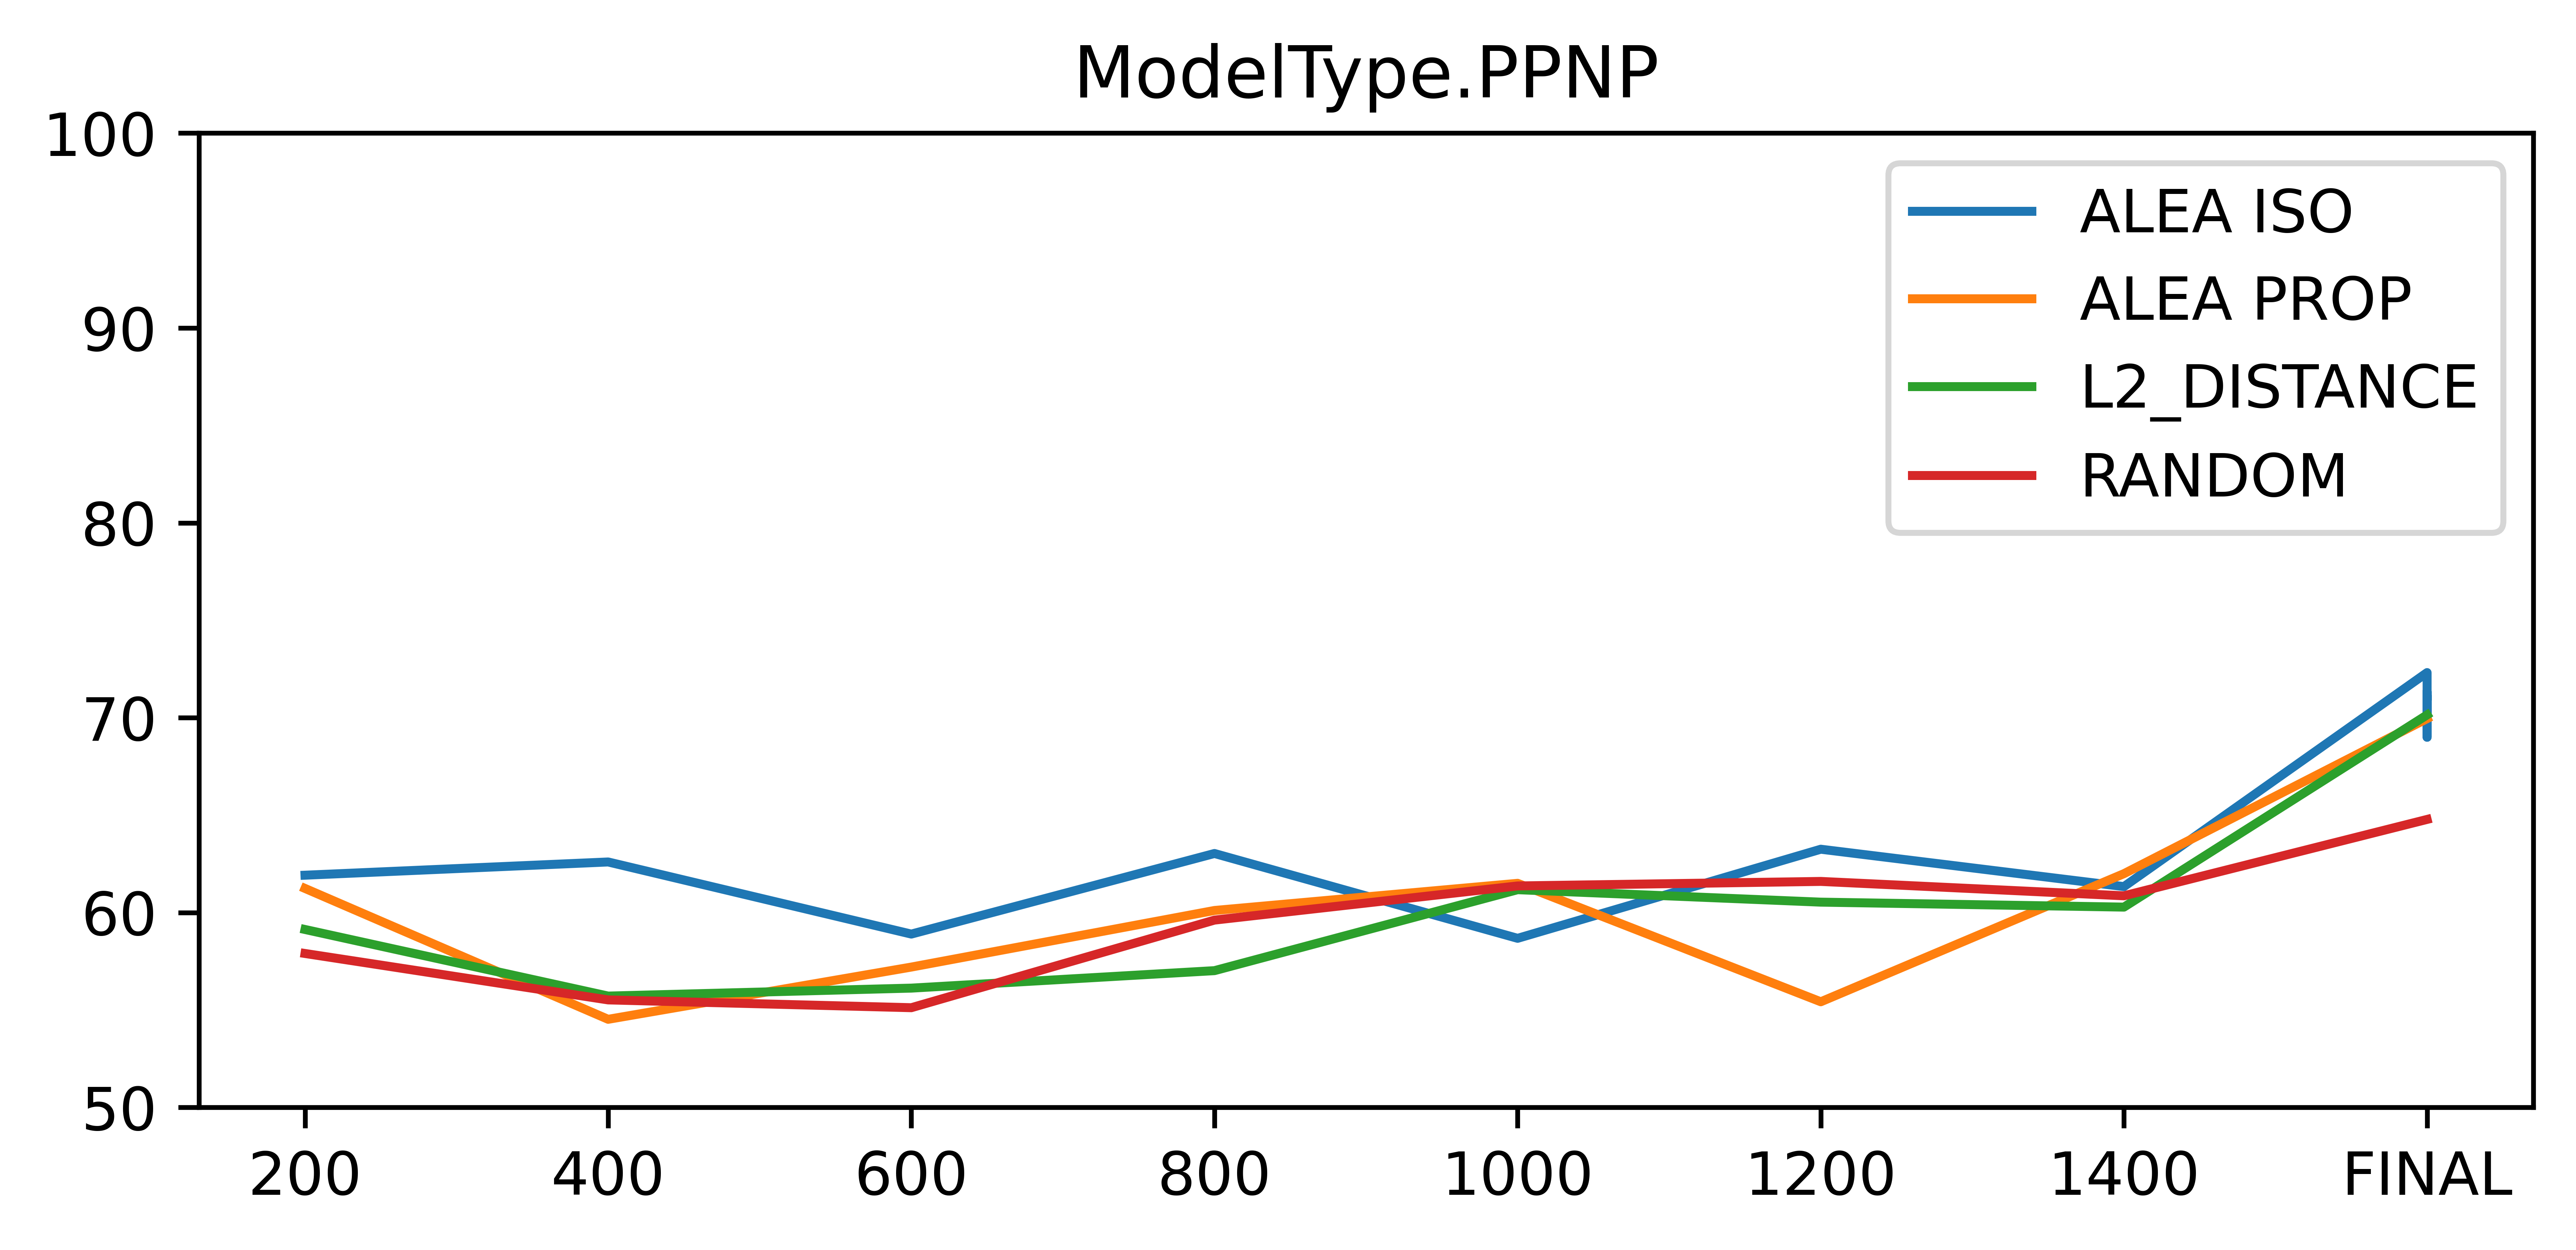

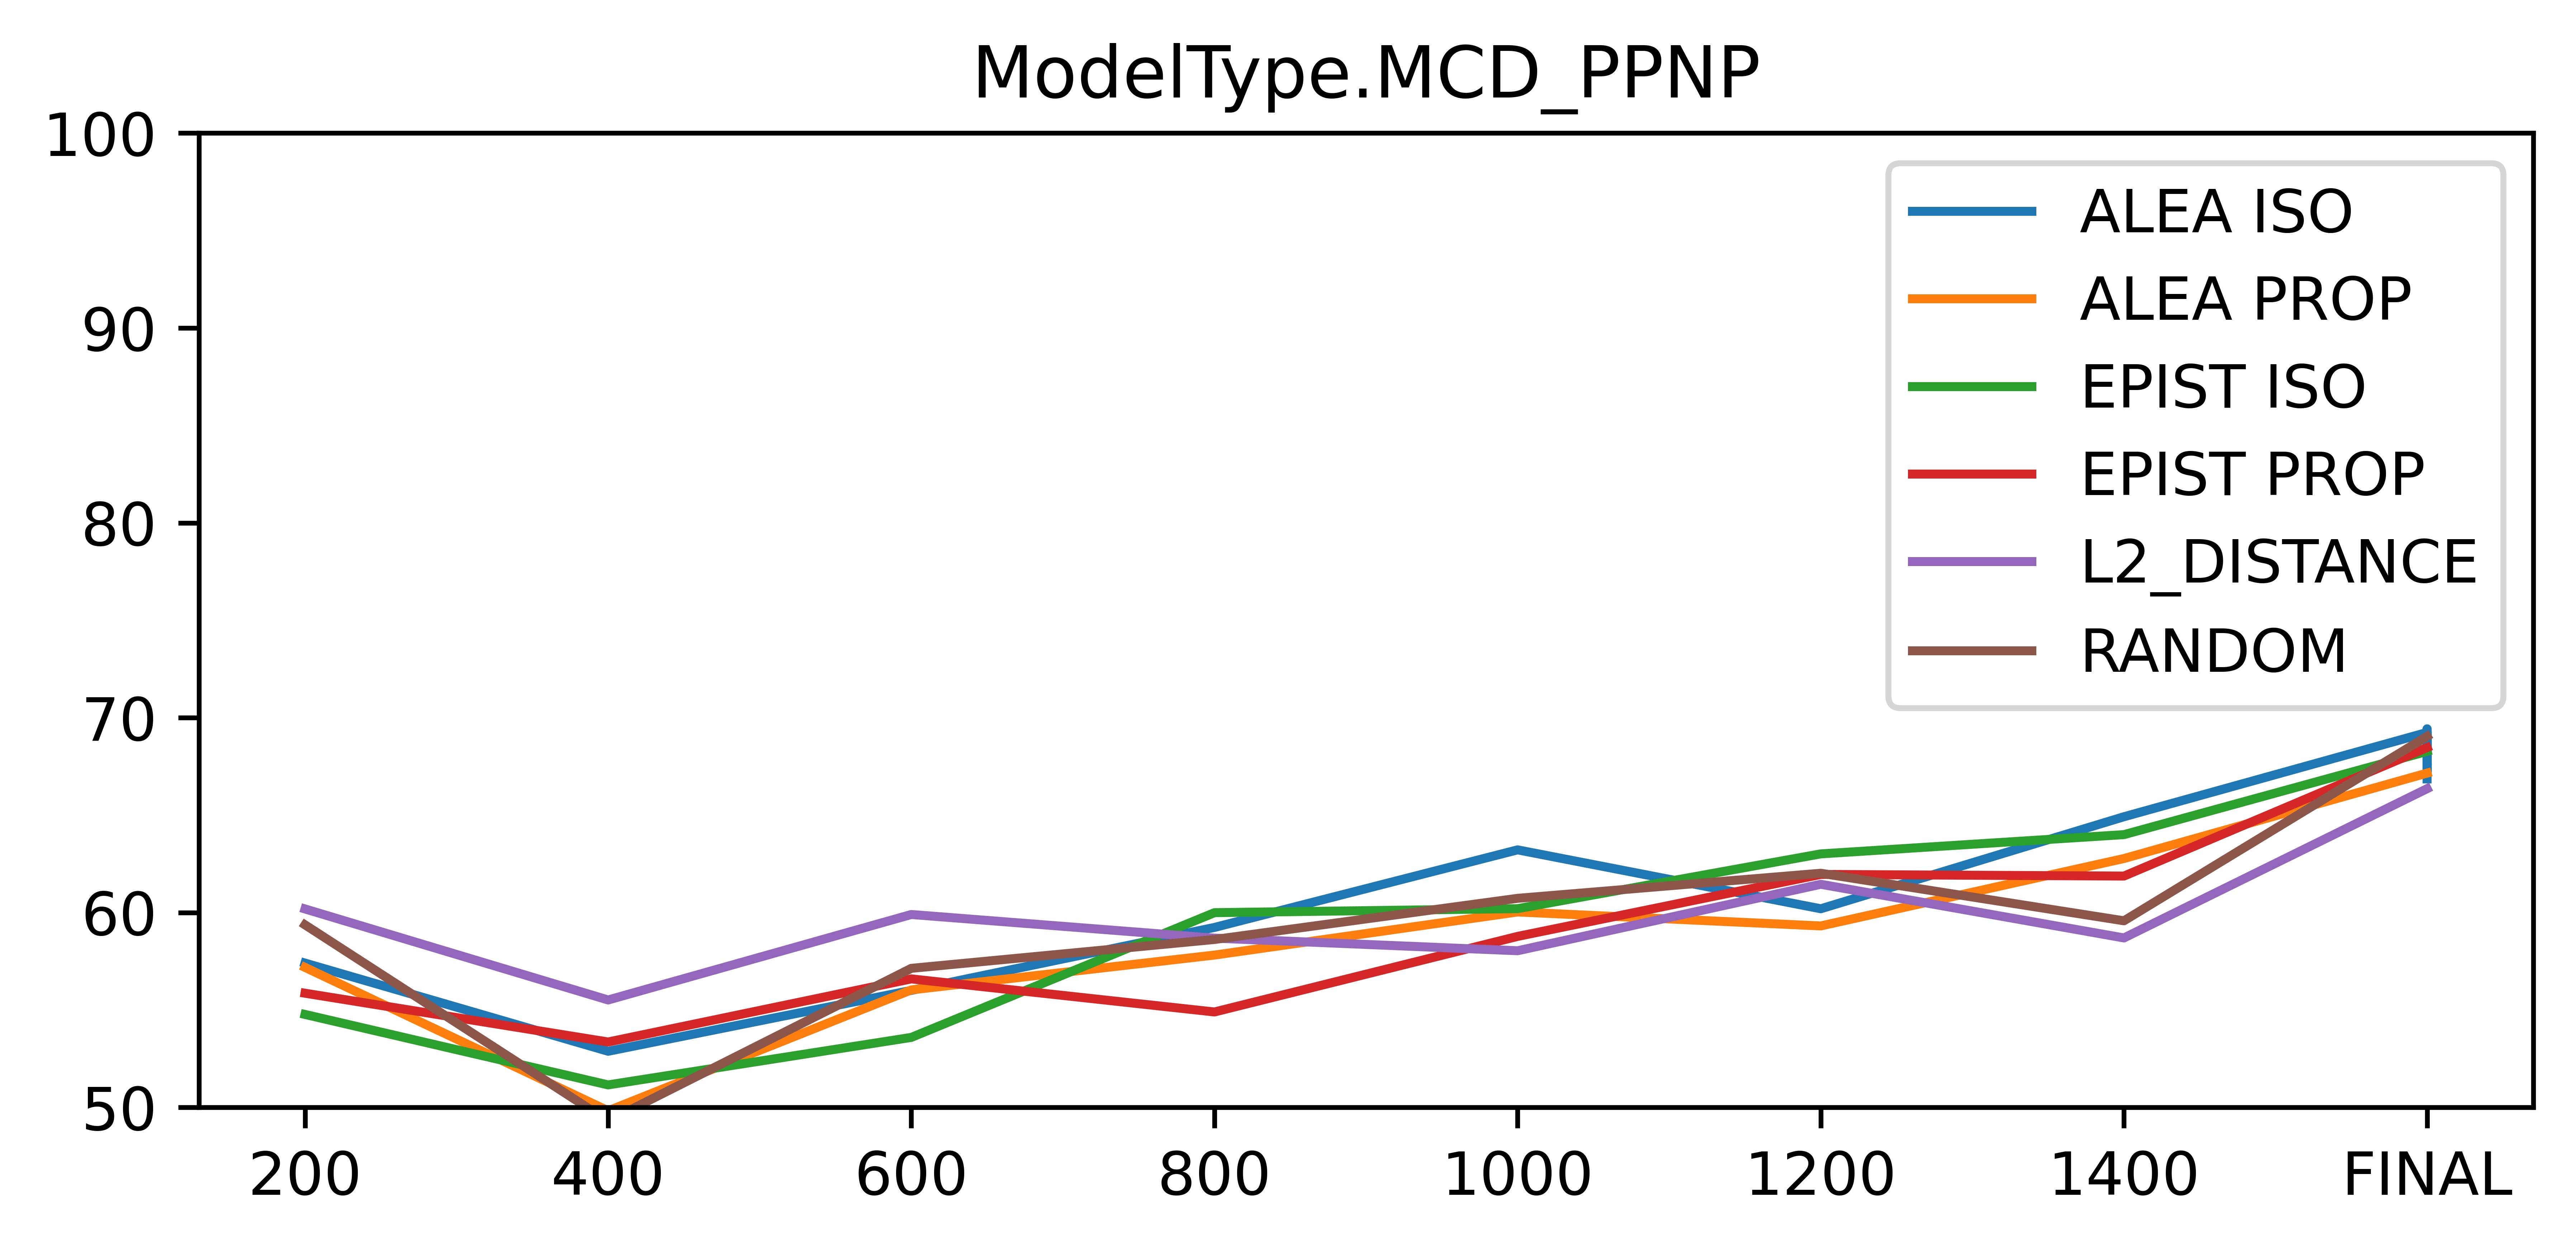

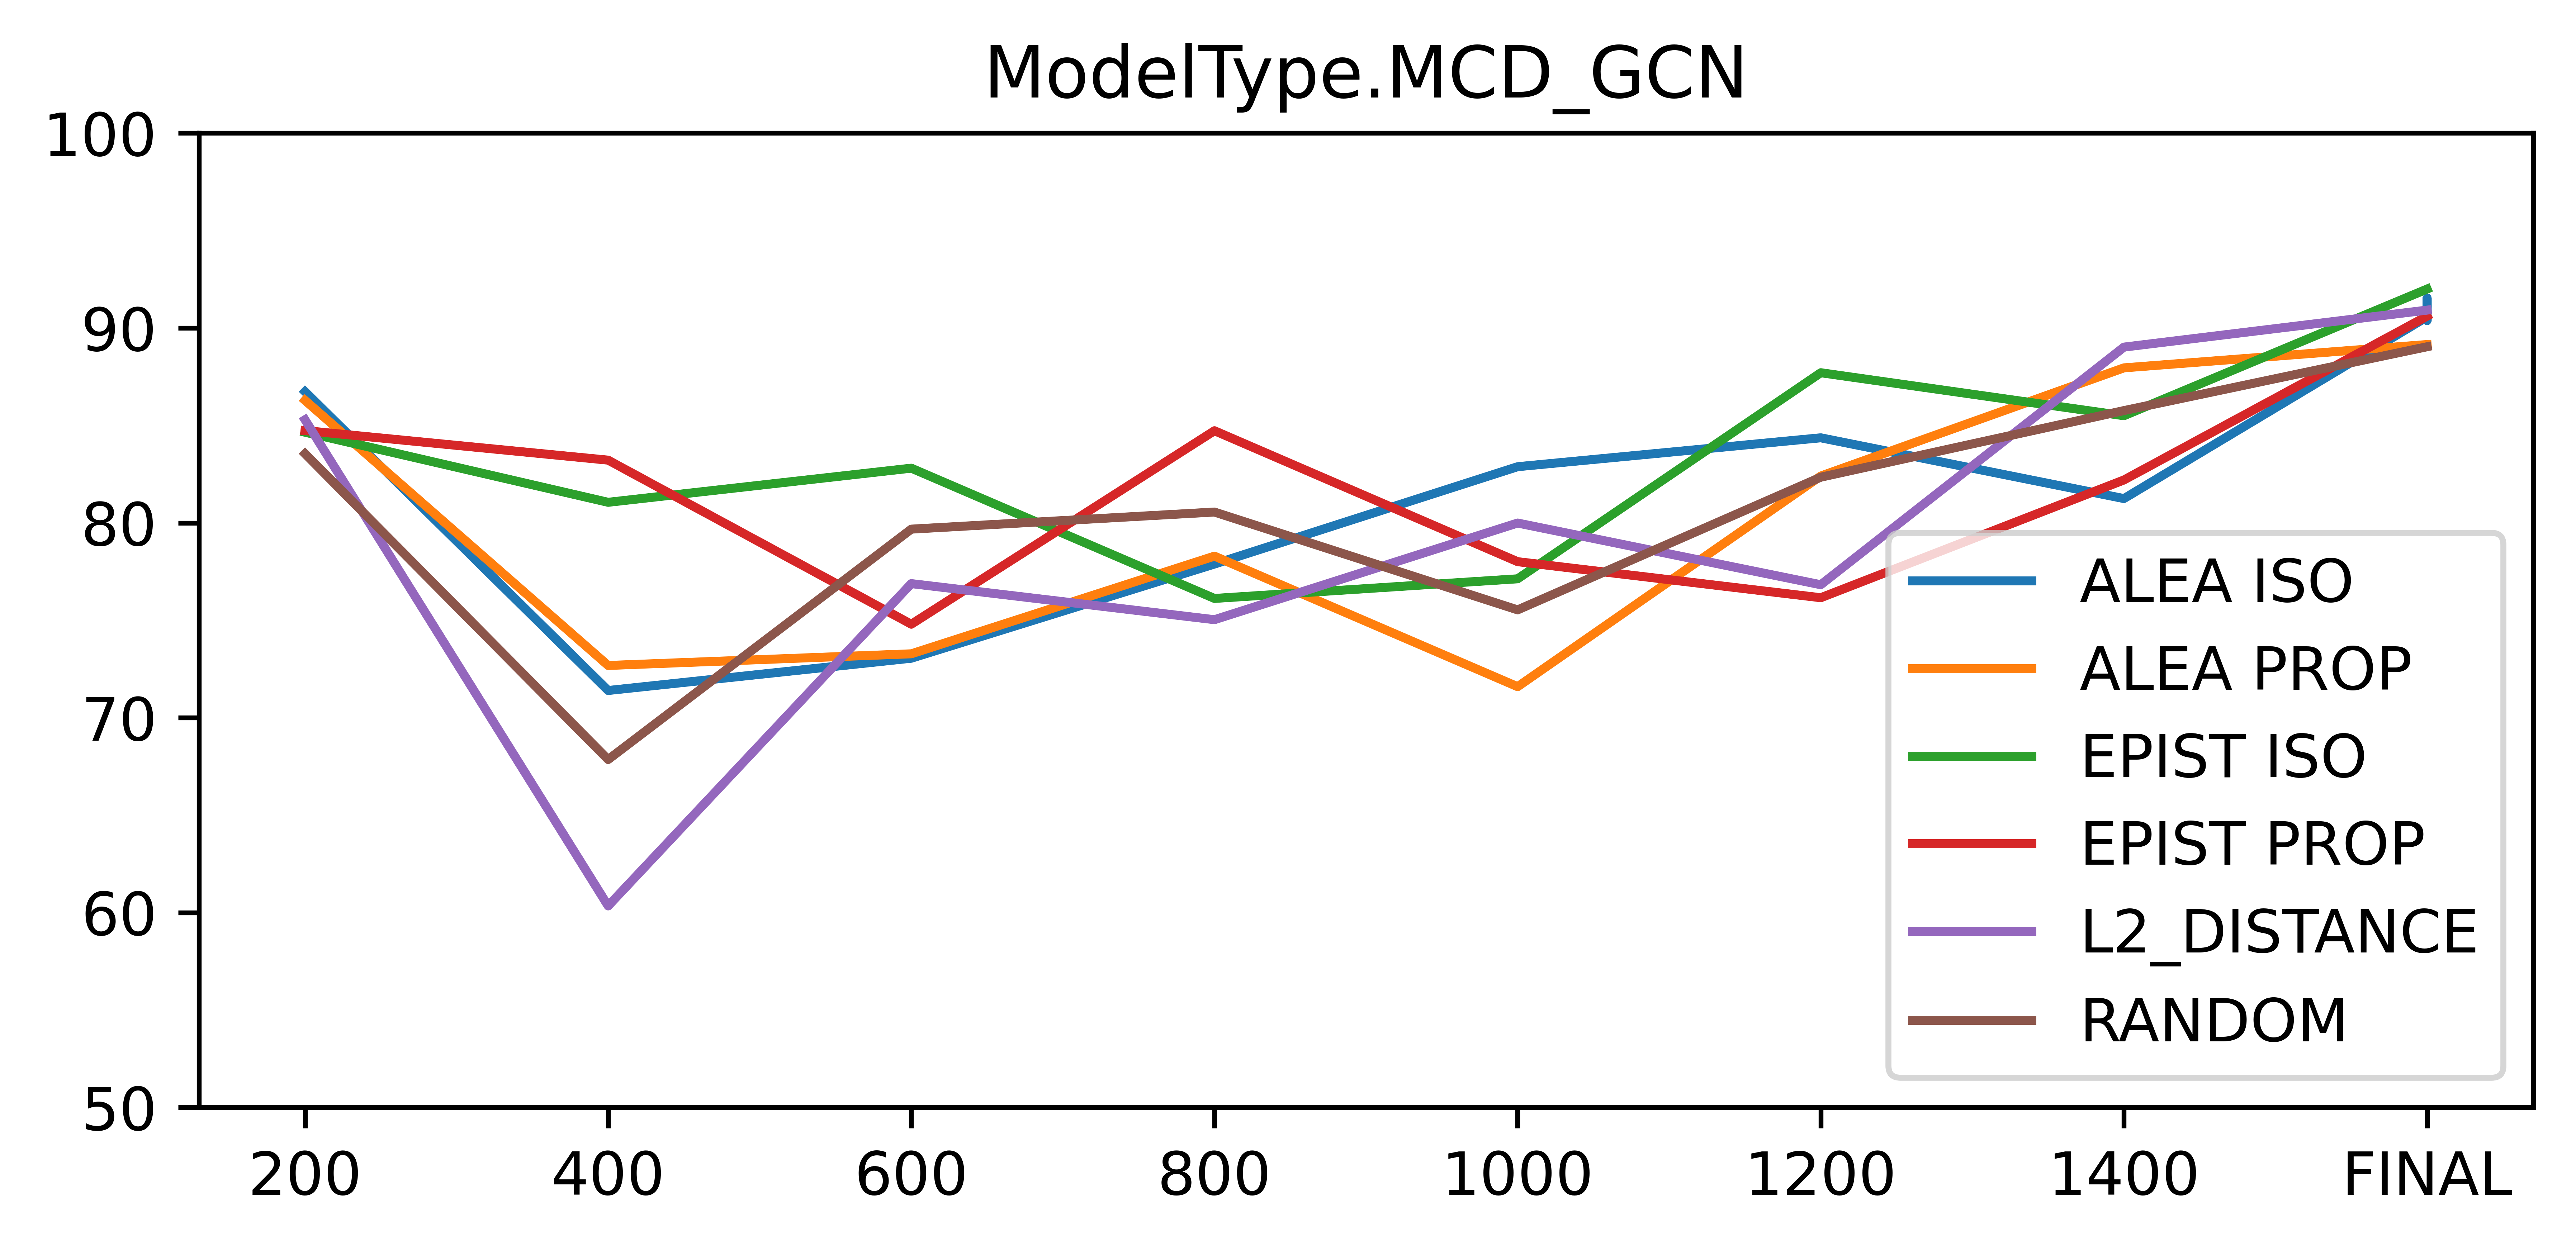

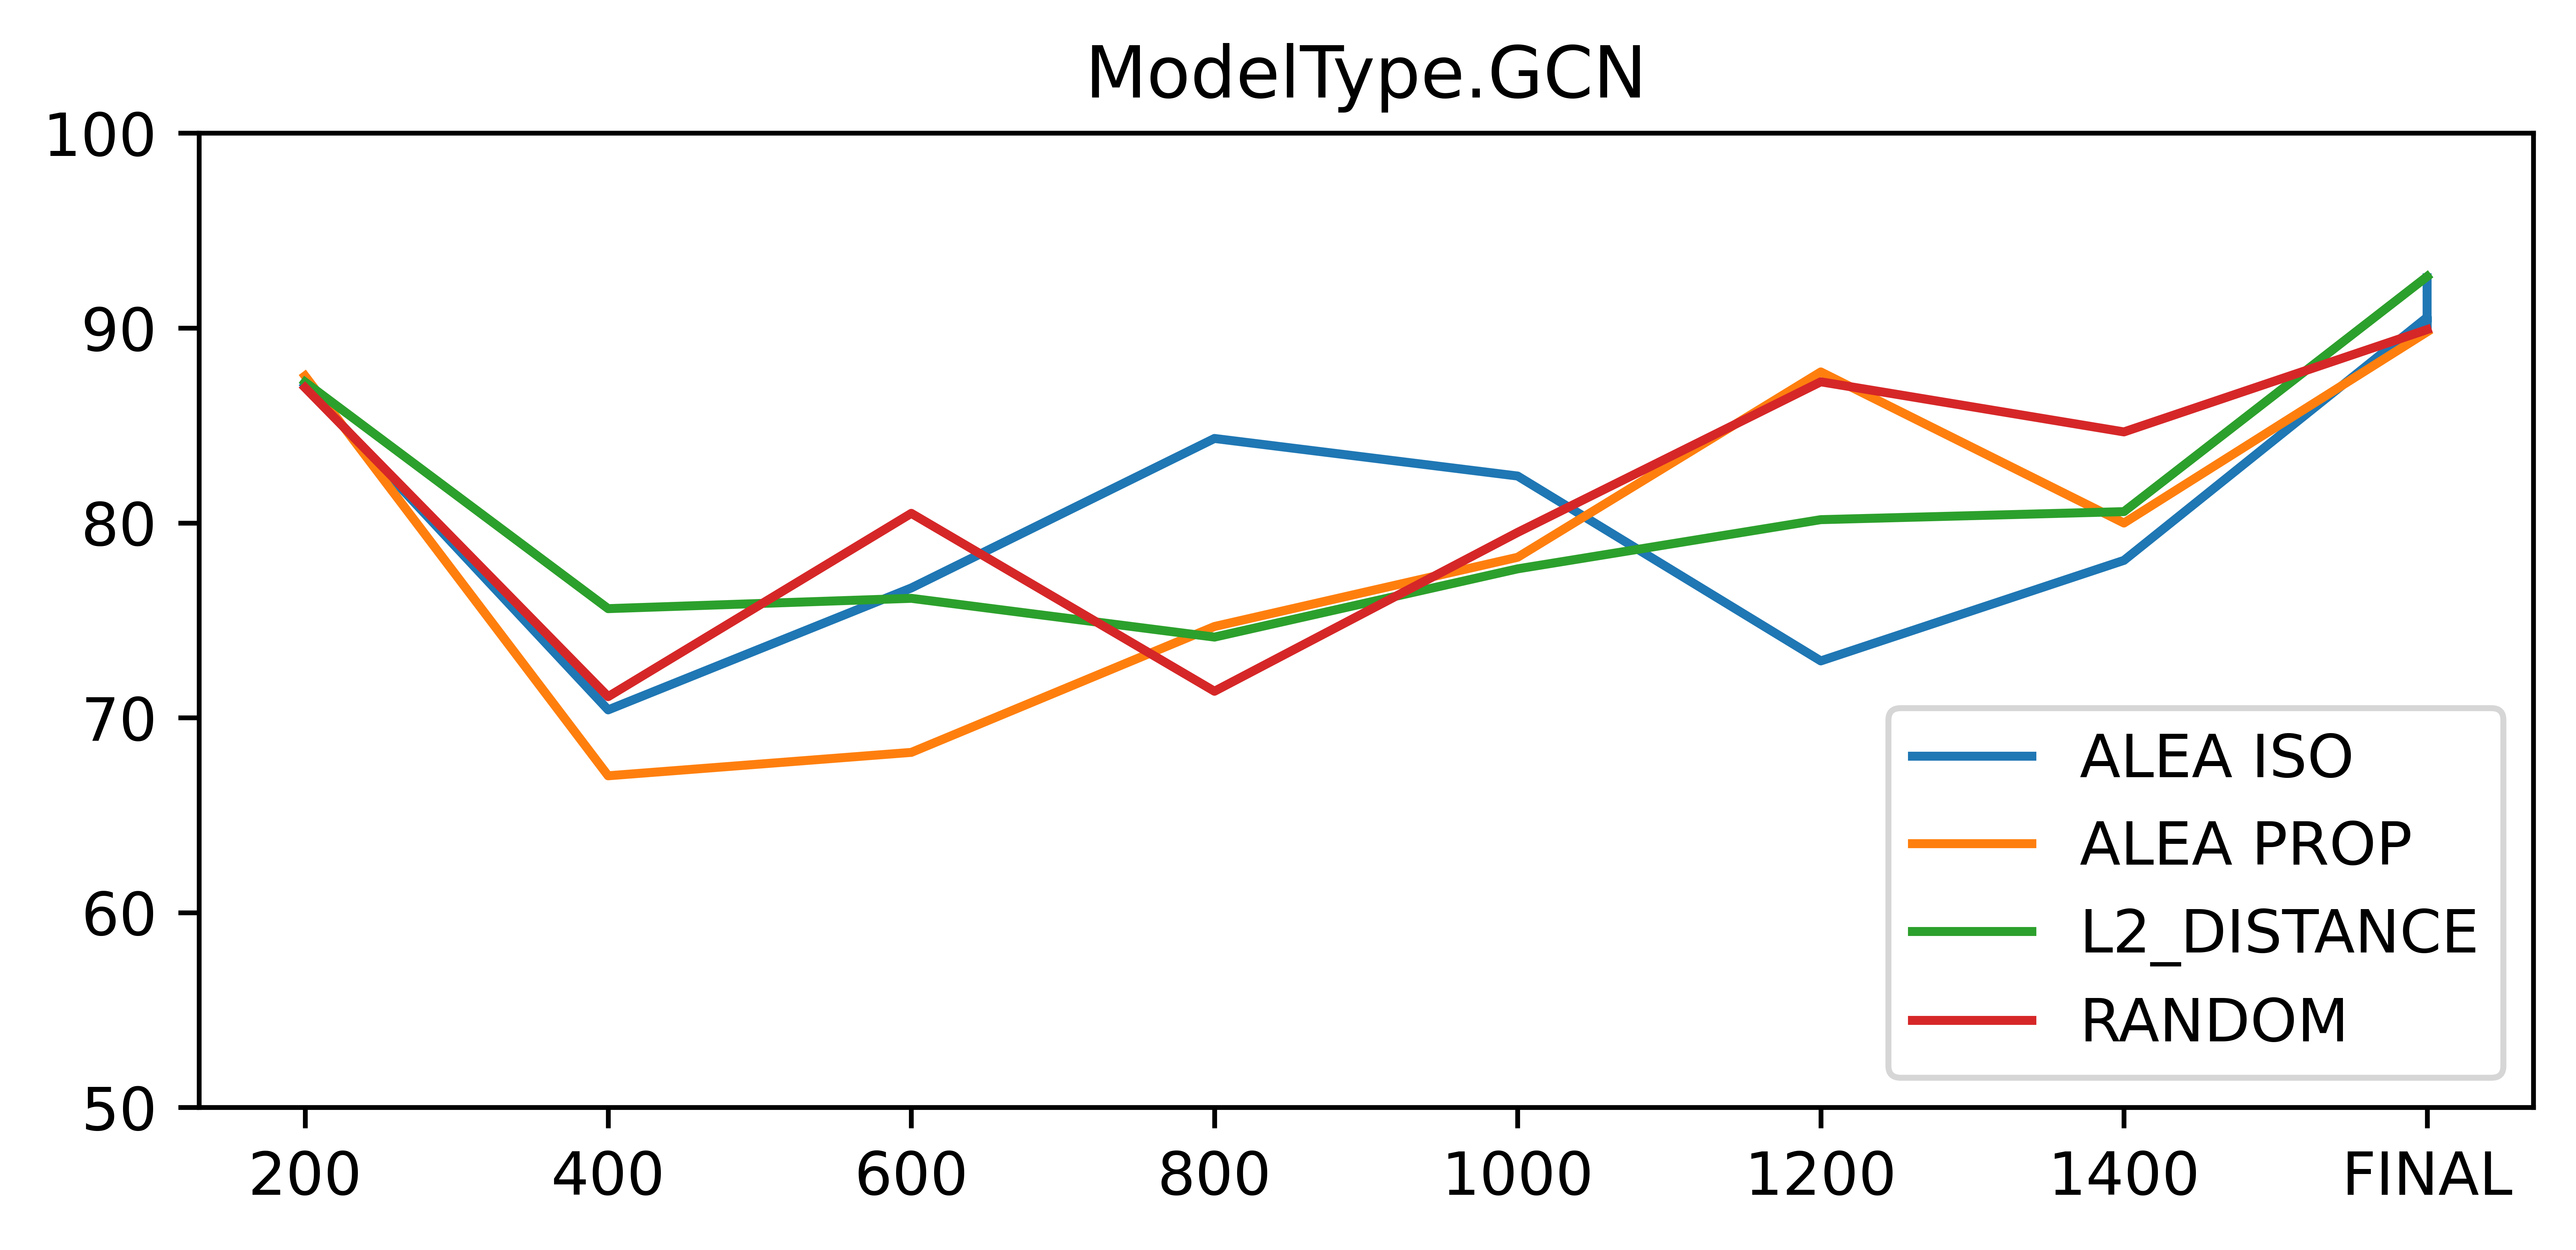

In [27]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

"""
https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
"""

def afterPoint(str):
    return str.split('.')[-1]

def getKey(str):
    if str == 'FINAL':
        return 99999999
    else:
        return int(str)
    
def sortBy(list, sorter):
    return [x for _, x in sorted(zip(sorter, list), key=lambda pair: getKey(pair[0]))]

SUMMARY_FINAL_ACCURACY = '/eval/VALTEST/PROPAGATED/accuracy'
AL_PREFIX = 'mean/al/'
AL_SUFFIX = '/VALTEST/PROPAGATED/accuracy'

tag = "active_learning_sbmal_v4"

api = wandb.Api(timeout=200)
runs = api.runs("tum_daml_ba_antoniooroz/Guided Research", {"tags" : tag})

"""
COLOR FROM: https://www.learnui.design/tools/data-color-picker.html#palette 21.02.2023
"""
COLOR_POSSIBILITIES = ['#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']

runs_per_model = {}

for run in runs:
    if run.config["debug"] or run.state != 'finished':
        continue
    
    model_type = str(run.config["model/type"])
    
    if model_type in runs_per_model:
        runs_per_model[model_type].append(run)
    else:
        runs_per_model[model_type] = [run]
        
for key, runs in runs_per_model.items():
    accuracies = []
    deviations = []
    timesteps = []
    selectors = []
    colors = []
    
    for run, color in zip(runs, range(len(runs))):
        model = afterPoint(run.config["model/type"])
        
        #if run.config['experiment/active_learning_l2_distance_use_centroids']==True and afterPoint(run.config['experiment/active_learning_selector'])=='L2_DISTANCE':
        #    continue
    
        active_learning_selector = afterPoint(run.config["experiment/active_learning_selector"])
        if active_learning_selector == "UNCERTAINTY":
            uncertainty_name = "ALEA" if afterPoint(run.config['experiment/active_learning_selector_uncertainty_mode']) == 'ALEATORIC' else 'EPIST'
            prop_name = 'ISO' if afterPoint(run.config['experiment/active_learning_selector_network_mode']) == 'ISOLATED' else 'PROP'
            active_learning_selector = f"{uncertainty_name} {prop_name}"

        for summary_key, summary_value in run.summary.items():
            if summary_key.startswith(AL_PREFIX) and summary_key.endswith(AL_SUFFIX):
                num = summary_key.replace(AL_PREFIX, '').replace(AL_SUFFIX, '')
                
                if num == '1':
                    continue
                
                accuracies.append(summary_value*100)
                deviations.append(run.summary[summary_key.replace('mean/', 'std/', 1)]*100)
                timesteps.append(num)
                selectors.append(active_learning_selector)
                colors.append(color)
                
        accuracies.append(run.summary[f"mean{SUMMARY_FINAL_ACCURACY}"]*100)
        deviations.append(run.summary[f"std{SUMMARY_FINAL_ACCURACY}"]*100)
        timesteps.append('FINAL')
        selectors.append(active_learning_selector)
        colors.append(color)
        
    accuracies = sortBy(accuracies, timesteps)
    deviations = sortBy(deviations, timesteps)
    selectors = sortBy(selectors, timesteps)
    colors = sortBy(colors, timesteps)
    timesteps = sortBy(timesteps, timesteps)
        
    df = pd.DataFrame(dict(x=timesteps, y=accuracies, err=deviations, label=selectors, color=colors))
    groups = df.groupby('label')
    
    fig, ax = plt.subplots(figsize=(7, 3), dpi=1200)
    ax.margins(0.05)
    for name, group in groups:
        ax.set_ylim([0.0, 0.8])
        ax.plot(group.x, group.y, '-', label=name)
        #ax.fill_between(group.x, group.y-group.err, group.y+group.err, label=name)
        ax.set_ylim(bottom=50, top=100)
        ax.yaxis.set_ticks(np.arange(50.0,105.0, 10))
    
    ax.legend(numpoints=1)
    plt.title(key)
    plt.show()
